In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jit, lax, vmap, grad, jacobian

import numpy as np
from read_traj import *

import matplotlib
import matplotlib.pyplot as plt

import scipy.optimize
import optax
import time

In [2]:
dt = 0.08268
mynumsteps = 80
ntvec = mynumsteps
drc = 2
m = drc

In [3]:
print('reading new data')
allden = np.load('tdci_heh+_AO_diagonalized_cycle_raw.npz')
print('done reading new data')

reading new data
done reading new data


In [4]:
overlapAO = np.array([[1.0, 0.538415], [0.538415, 1.0]])
s, U = np.linalg.eig(overlapAO)

In [5]:
# assume p is of size drc x drc    #
def MLham(theta,p):
    beta1 = theta[:drc**4].reshape((drc**2, drc**2))
    gamma1 = theta[drc**4:].reshape((drc**2, drc**2))
    # produce real target
    x = jnp.real(p).reshape((drc**2))
    y = jnp.imag(p).reshape((drc**2))
    rmat = (beta0 + jnp.matmul(x, beta1)).reshape((drc, drc))
    # produce imag target
    qmat = (gamma0 + jnp.matmul(y, gamma1)).reshape((drc, drc))
    # keep in mind that
    h = 0.5*(rmat + rmat.T) + 0.5j*(qmat - qmat.T)
    return h
    #return np.linalg.inv(np.diag(np.sqrt(s))) @ U.T @ h @ U @  np.linalg.inv(np.diag(np.sqrt(s)))

# def MLham(theta,p):
#     pmat = p.reshape((drc,drc))
#     beta0 = jnp.array([[theta[0], theta[1] + 1j*theta[2]],[theta[1] - 1j*theta[2], theta[3]]])
#     ham = beta0 + theta[4] *(pmat) + theta[5] * (pmat**2)
#     hamR = jnp.real(ham)
#     hamI = jnp.imag(ham)
#     h = 0.5*(hamR + hamR.T) + 0.5j*(hamI - hamI.T)
#     return h

def expderiv(d, u, w):
    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(d)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(d, d)
    denom = offdiagmask * (s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    prederivamat = jnp.einsum('ij,jk,kl->il',u.conj().T,w,u) 
    derivamat = prederivamat * mask
    return jnp.einsum('ij,jk,kl->il',u,derivamat,u.conj().T)

def expderiv2(d, u, w):
    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(d)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(d, d)
    denom = offdiagmask * (s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    prederivamat = jnp.einsum('ij,abjk,kl->ilab',u.conj().T,w,u) 
    derivamat = jnp.einsum('ilab,il->ilab',prederivamat,mask)
    return jnp.einsum('ij,jkab,kl->ilab',u,derivamat,u.conj().T)

def expderiv3(d, u, w):
    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(d)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(d, d)
    denom = offdiagmask * (s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    prederivamat = jnp.einsum('ij,abcdjk,kl->ilabcd',u.conj().T,w,u) 
    derivamat = jnp.einsum('ilabcd,il->ilabcd',prederivamat,mask)
    return jnp.einsum('ij,jkabcd,kl->ilabcd',u,derivamat,u.conj().T)

def xicomp(theta, p, evals, evecs):
    x = jnp.real(p)
    y = jnp.imag(p)
    beta1 = theta[:drc**4].reshape((drc**2, drc**2))
    gamma1 = theta[drc**4:].reshape((drc**2, drc**2))
    beta1 = beta1.reshape((drc,drc,drc,drc))
    gamma1 = gamma1.reshape((drc,drc,drc,drc))
    dHdX = 0.25*(beta1 + jnp.transpose(beta1, axes=[0, 1, 3, 2]))
    dHdY = 0.25*(gamma1 - jnp.transpose(gamma1, axes=[0, 1, 3, 2]))
    dHdP = dHdX + dHdY
    dHdPbar = dHdX - dHdY
    jacP = expderiv2(evals, evecs, dHdP)
    jacPbar = expderiv2(evals, evecs, dHdPbar)
    return jacP, jacPbar

def dUdtheta(theta, p, evals, evecs):
    x = jnp.real(p)
    y = jnp.imag(p)
    beta1 = theta[:drc**4].reshape((drc**2, drc**2))
    gamma1 = theta[drc**4:].reshape((drc**2, drc**2))
    
    dHdtheta = 0.5*jnp.einsum('ab,ck,dl->abcdkl',x.reshape((drc,drc)),jnp.eye(drc),jnp.eye(drc))
    dHdtheta += 0.5*jnp.einsum('ab,cl,dk->abcdkl',x.reshape((drc,drc)),jnp.eye(drc),jnp.eye(drc))
    jacbeta = expderiv3(evals, evecs, dHdtheta)
    
    dHdtheta = 0.5j*jnp.einsum('ab,ck,dl->abcdkl',y.reshape((drc,drc)),jnp.eye(drc),jnp.eye(drc))
    dHdtheta -= 0.5j*jnp.einsum('ab,cl,dk->abcdkl',y.reshape((drc,drc)),jnp.eye(drc),jnp.eye(drc))
    jacgamma = expderiv3(evals, evecs, dHdtheta)
    
    tmp = [jacbeta.reshape((drc,drc,drc**4)), jacgamma.reshape((drc,drc,drc**4))]
    return jnp.concatenate(tmp, axis=2)

In [6]:
def adjgrad(theta, Ptilde):
    tvec = dt*jnp.arange(ntvec)
    P0 = Ptilde[0,:,:]
    propagated_dens = [P0]
    H0 = MLham(theta,P0)
    evals, evecs = jnp.linalg.eigh(H0)
    U0 = evecs @ jnp.diag(jnp.exp(-1j*dt*evals)) @ evecs.conj().T
    P1 = U0 @ P0 @ U0.conj().T
    propagated_dens.append( P1 )
    # 
    def bodyfun(i, dtup):
        dl, dvals, dvecs, dU = dtup
        P0 = dl[i, :, :]
        P1 = dl[i+1, :, :]
        H1 = MLham(theta,P1)
        evals, evecs = jnp.linalg.eigh(H1)
        dvals = dvals.at[i+1].set( evals )
        dvecs = dvecs.at[i+1].set( evecs )
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        dU = dU.at[i+1].set( U1 )
        P2 = U1 @ P0 @ U1.conj().T
        dl = dl.at[i+2].set( P2 )
        return (dl, dvals, dvecs, dU)
    # 
    alldens = jnp.concatenate([jnp.stack(propagated_dens), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    allevals = jnp.concatenate([jnp.expand_dims(evals,0), jnp.zeros((ntvec-1, drc))], axis=0)
    allevecs = jnp.concatenate([jnp.expand_dims(evecs,0), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    allU = jnp.concatenate([jnp.expand_dims(U0,0), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    ftup = lax.fori_loop(0, ntvec-1, bodyfun, (alldens, allevals, allevecs, allU))
    Pstack, allevals, allevecs, allU = ftup
    # 
    def bodylamb(i, dl):
        k = ntvec - i
        newlamb = Pstack[k, :, :] - Ptilde[k, :, :]
        xiak = xicomp(theta, Pstack[k].reshape((-1)), -2j*dt*allevals[k], allevecs[k])
        xibk = xicomp(theta, Pstack[k].reshape((-1)), 2j*dt*allevals[k], allevecs[k])
        # if i <---> k correspond, then i-1 <---> k+1 correspond
        newlamb += jnp.einsum('ij,ijkl->kl',dl[i-1] @ allU[k] @ Pstack[k-1], (-2j*dt*xiak[0]).conj())
        newlamb += jnp.einsum('ij,ijkl->kl',dl[i-1] @ allU[k] @ Pstack[k-1], (-2j*dt*xiak[1]).conj()).conj()
        newlamb += jnp.einsum('ij,ijkl->kl',Pstack[k-1] @ allU[k].conj().T @ dl[i-1], (2j*dt*xibk[0]).conj())
        newlamb += jnp.einsum('ij,ijkl->kl',Pstack[k-1] @ allU[k].conj().T @ dl[i-1], (2j*dt*xibk[1]).conj()).conj()
        newlamb += allU[k+1].conj().T @ dl[i-2] @ allU[k+1]
        return dl.at[i].set( newlamb )
    # 
    lambfinal = Pstack[ntvec, :, :] - Ptilde[ntvec, :, :]
    lambnext = Pstack[ntvec-1, :, :] - Ptilde[ntvec-1, :, :]
    xiak = xicomp(theta, Pstack[ntvec-1].reshape((-1)), -2j*dt*allevals[ntvec-1], allevecs[ntvec-1])
    xibk = xicomp(theta, Pstack[ntvec-1].reshape((-1)), 2j*dt*allevals[ntvec-1], allevecs[ntvec-1])
    lambnext += jnp.einsum('ij,ijkl->kl',lambfinal @ allU[ntvec-1] @ Pstack[ntvec-2], (-2j*dt*xiak[0]).conj())
    lambnext += jnp.einsum('ij,ijkl->kl',lambfinal @ allU[ntvec-1] @ Pstack[ntvec-2], (-2j*dt*xiak[1]).conj()).conj()
    lambnext += jnp.einsum('ij,ijkl->kl',Pstack[ntvec-2] @ allU[ntvec-1].conj().T @ lambfinal, (2j*dt*xibk[0]).conj())
    lambnext += jnp.einsum('ij,ijkl->kl',Pstack[ntvec-2] @ allU[ntvec-1].conj().T @ lambfinal, (2j*dt*xibk[1]).conj()).conj()
    lambcat = jnp.concatenate([jnp.expand_dims(lambfinal,0), jnp.expand_dims(lambnext, 0), jnp.zeros((ntvec-2, drc, drc))])
    alllamb = lax.fori_loop(2, ntvec, bodylamb, lambcat)
    lambstack = jnp.flipud( jnp.stack(alllamb, axis=0) )    
    # 
    def bodygrad(k, gL):
        tmp1 = -2j*dt*dUdtheta(theta, Pstack[k], -2j*dt*allevals[k], allevecs[k])
        term1 = jnp.einsum('ija,jk,kl->ila',tmp1,Pstack[k-1],allU[k].conj().T)
        term2 = term1.transpose((1,0,2)).conj()
        return gL + jnp.real(jnp.einsum('il,ila->a',lambstack[k],(term1+term2).conj()))
    # 
    tmp1 = -1j*dt*dUdtheta(theta, Pstack[0], -1j*dt*allevals[0], allevecs[0])
    term1 = jnp.einsum('ija,jk,kl->ila',tmp1,Pstack[0],allU[0].conj().T)
    term2 = term1.transpose((1,0,2)).conj()
    initgradL = jnp.real(jnp.einsum('il,ila->a',lambstack[0],(term1+term2).conj()))
    gradL = lax.fori_loop(1, ntvec, bodygrad, initgradL)/ntvec
    return gradL
    
def MMUT_Prop_HSB(theta, initial_density):
    tvec = dt*jnp.arange(ntvec)
    P0 = initial_density.reshape((drc, drc))
    propagated_dens = [P0]
    H0 = MLham(theta,P0)
    evals, evecs = jnp.linalg.eigh(H0)
    U0 = evecs @ jnp.diag(jnp.exp(-1j*dt*evals)) @ evecs.conj().T
    P1 = U0 @ P0 @ U0.conj().T
    propagated_dens.append( P1 )
    def bodyfun(i, dl):
        P0 = dl[i, :, :]
        P1 = dl[i+1, :, :]
        H1 = MLham(theta,P1)
        evals, evecs = jnp.linalg.eigh(H1)
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        P2 = U1 @ P0 @ U1.conj().T
        return dl.at[i+2].set( P2 )
    
    alldens = jnp.concatenate([jnp.stack(propagated_dens), jnp.zeros((ntvec-1, drc, drc))], axis=0) 
    fdl = lax.fori_loop(0, ntvec-1, bodyfun, alldens)
    
    return fdl

def loss(theta, thisden):
    thisic = thisden[0,:,:].reshape((-1))
    mlprop = MMUT_Prop_HSB(theta, thisic)
    resid = mlprop - thisden[:ntvec+1, :, :]
    mse = 0.5*jnp.real(jnp.sum(jnp.conj(resid)*resid))/ntvec
    return mse

In [7]:
# JIT AND VMAP AND ALL THAT JAZZ
jloss = jit(loss)
jadjgrad = jit(adjgrad)

aggloss = vmap(loss, in_axes=(None,0), out_axes=0)
jaggloss = jit(aggloss)

aggadjgrad = vmap(adjgrad, in_axes=(None,0), out_axes=0)
jaggadjgrad = jit(aggadjgrad)

# define the training set
trnind = np.arange(45,56,dtype=np.int16)
#trnind = np.arange(0,4,dtype=np.int16)
trnden = np.stack(allden)[trnind]
jtrnden = jnp.array(trnden)

In [8]:
def jaxobj(x):
    return jnp.mean(aggloss(x,jtrnden))

jaxobj = vmap(jaxobj,in_axes=0,out_axes=0)
jjaxobj = jit(jaxobj)

In [9]:
numparams = 2*drc**4
#numparams = 6
rng = np.random.default_rng(seed=42)
beta0 = 0.6*rng.standard_normal(size=4) - 0.3
gamma0 = 0.6*rng.standard_normal(size=4) - 0.3
numtheta = 10000
theta0NP = 0.6*rng.standard_normal(size=(numparams) * numtheta) - 0.3
theta0JNP = jnp.array(theta0NP).reshape(numtheta, (numparams ))
test = jjaxobj(theta0JNP)
theta0 = np.array(theta0JNP[jnp.argmin(test),:])

propagating trajectory


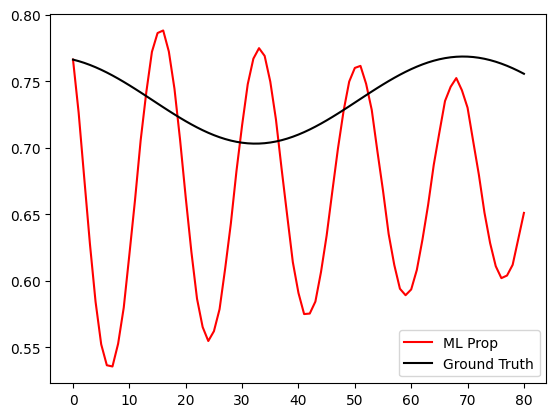

In [10]:
i = 46
ic = allden[i][0,:,:].reshape((-1))
print('propagating trajectory')
mlprop = MMUT_Prop_HSB(theta0, ic)

plt.plot(jnp.real(mlprop[:,0,0]),color='red')
plt.plot(jnp.real(allden[i][:mynumsteps+1,0,0]),color='black')
plt.legend(['ML Prop', 'Ground Truth'])
#plt.savefig('linear_model_pretrain_mean.pdf')
plt.show()
plt.close()

In [11]:
# WRAPPERS TO ENABLE USE OF SCIPY OPTIMIZERS
def siobj(x):
    jx = jnp.array(x)
    return np.mean(jaggloss(jx,jtrnden))

def sigrad(x):
    jx = jnp.array(x)
    thisgrad = jaggadjgrad(jx,jtrnden)
    return np.array(jnp.mean( thisgrad, axis=0 ))

In [12]:
# UNCOMMENT THE FOLLOWING BLOCK IF YOU WISH TO unit test the adjoint method
jaxgradloss = grad(loss, 0)
jaxres = jaxgradloss(theta0, allden[0])
myres = jadjgrad(theta0, allden[0])
print('|| adjgrad - jaxgrad ||:')
print(jnp.linalg.norm(jaxres - myres))

# # check loss (before training) against loss evaluated at true theta
# print('pretraining loss value: ' + str(siobj(theta0)))
# print('true theta loss value: ' + str(siobj(thetatrue)))

# print('all true theta losses: ')
# print(jaggloss(jnp.array(thetatrue),jnp.stack(allden),
#                             jnp.stack(alltme),jnp.stack(allfrq),
#                             jnp.stack(allamp),jnp.stack(norm_direc)))

|| adjgrad - jaxgrad ||:
0.13341822197795603


In [13]:
# UNCOMMENT THE FOLLOWING BLOCK IF YOU WISH TO USE BFGS
# def mycb(x):
#     thisloss = siobj(x)
#     print("iter {:d} loss {:0.6e}".format(mycb.iteration, thisloss))
#     mycb.iteration += 1
# mycb.iteration = 0
# res = scipy.optimize.minimize( siobj, 
#                                x0 = theta0,
#                                method = 'bfgs',
#                                callback = mycb,
#                                jac = sigrad,
#                                options = {'disp': True, 'gtol': 1e-30} )
# trainedtheta = res.x
######################################################################

In [14]:
lr = 1e-1
theta = np.copy(theta0)
maxiters = 1000
i = 46
ic = allden[i][0,:,:].reshape((-1))
preds = []
for j in range(maxiters):
    #thisgrad = jadjgrad(theta, allden[i])
    thisgrad = np.array(jnp.mean(jaggadjgrad(theta,jtrnden),axis=0))
    theta -= lr*thisgrad
    myloss = np.mean(jaggloss(theta, jtrnden))
    if j % 100 == 0:
    #if True:
        #pred = predtraj(jalltraj[0,0,:],theta)
        pred = MMUT_Prop_HSB(theta, ic)
        preds.append(pred)
        lr *= 0.999
        print([j, myloss, np.linalg.norm(thisgrad)])

[0, DeviceArray(0.03481015, dtype=float64), 0.07537740928857849]
[100, DeviceArray(0.14338168, dtype=float64), 0.22202017598065496]
[200, DeviceArray(0.04775089, dtype=float64), 0.10797146975910966]
[300, DeviceArray(0.0314954, dtype=float64), 0.04622566090148588]
[400, DeviceArray(0.02548258, dtype=float64), 0.03656449233800642]
[500, DeviceArray(0.02139815, dtype=float64), 0.024485212032487]
[600, DeviceArray(0.0190666, dtype=float64), 0.02264867863288583]
[700, DeviceArray(0.01701928, dtype=float64), 0.016562104998063078]
[800, DeviceArray(0.01552081, dtype=float64), 0.014552502405998194]
[900, DeviceArray(0.01449473, dtype=float64), 0.013616763750916262]


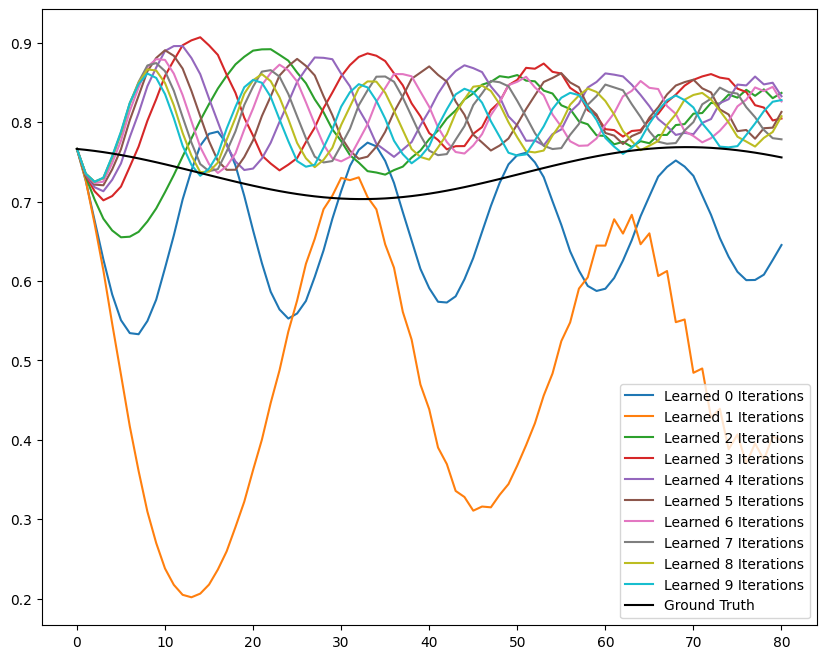

In [15]:
plt.rcParams["figure.figsize"] = (10,8)
for k in range(len(preds)):
    plt.plot(jnp.real(preds[k][:,0,0]))
plt.plot(jnp.real(allden[46][:mynumsteps+1,0,0]),color='black')
learned = ['Learned ' + str(n) + ' Iterations' for n in range(len(preds))]
plt.legend(learned + ['Ground Truth'])
#plt.savefig('linear_model_pretrain_mean_GD.pdf')
plt.show()
plt.close()

In [16]:
# UNCOMMENT THE FOLLOWING BLOCK IF YOU WISH TO USE L-BFGS-B
res = scipy.optimize.minimize( siobj, 
                               x0 = theta0,
                               method = 'L-BFGS-B',
                               jac = sigrad,
                               options = {'iprint': 1, 'ftol': 1e-30, 'gtol': 1e-30} )
trainedtheta = res.x
# ######################################################################

# UNCOMMENT THE FOLLOWING BLOCK IF YOU WISH TO USE trust region with SR1 Hessian approximation
# res = scipy.optimize.minimize( siobj, 
#                                x0 = theta0,
#                                method = 'trust-constr',
#                                hess = scipy.optimize.SR1(),
#                                jac = sigrad,
#                                options = {'disp': True, 'verbose': 2, 'xtol': 1e-30, 'gtol': 1e-30} )
# trainedtheta = res.x
######################################################################

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43881D-02    |proj g|=  3.96225D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


   32      1     21      1     0     0   3.962D-02   3.439D-02
  F =   3.4388075202843954E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [17]:
# UNCOMMENT THIS NEXT BLOCK IF YOU WANT TO USE OPTAX
# def myobj(jx):
#     return jnp.mean(jaggloss(jx,jtrnden,jtrntme,jtrnfrq,jtrnamp,jtrnnd))

# def mygrad(jx):
#     thisgrad = jaggadjgrad(jx,jtrnden,jtrntme,jtrnfrq,jtrnamp,jtrnnd)
#     return jnp.mean( thisgrad, axis=0 )

# def fit(params: optax.Params, optimizer: optax.GradientTransformation, nfs, dispint, saveint) -> optax.Params:
#     opt_state = optimizer.init(params)

#     def step(params, opt_state):
#         grads = mygrad(params)
#         updates, opt_state = optimizer.update(grads, opt_state, params)
#         params = optax.apply_updates(params, updates)
#         return params, opt_state

#     for i in range(nfs):
#         params, opt_state = step(params, opt_state)
#         if i % dispint == 0:
#             loss_value = myobj(params)
#             print(f'step {i}, loss: {loss_value}')
#         if i % saveint == 0:
#             np.savez('optaxADJMMUTtheta.npz',trainedtheta=params)
#             with open("optaxADJMMUTloss.txt",'a',encoding = 'utf-8') as f:
#                 f.write(f'step {i}, loss: {loss_value}\n')
    
#     return params

# optimizer = optax.fromage(learning_rate=1e-3)
# opt_state = optimizer.init(jnp.array(theta0))
# trainedtheta = fit(jnp.array(theta0), optimizer, 10000, 1, 10)
######################################################################

In [18]:
#np.savez('linear_model_trainedtheta_raw.npz', trainedtheta=trainedtheta)

In [19]:
# i = 46
# ic = allden[i][0,:,:].reshape((-1))
# mlprop = MMUT_Prop_HSB(trainedtheta, ic)
# print(0.5*jnp.linalg.norm(mlprop - allden[i][:mynumsteps+1,:,:])**2)
# plt.plot(jnp.real(mlprop[:,0,0]),color='red')
# plt.plot(jnp.real(allden[i][:mynumsteps+1,0,0]),color='black')
# plt.legend(['ML Prop', 'Ground Truth'])
# plt.savefig('linear_model_posttrain1_raw.pdf')
# plt.show()
# plt.close()

# plt.plot(jnp.real(mlprop[3900:4000,0,0]),color='red')
# plt.plot(jnp.real(allden[i][3900:4000,0,0]),color='black')
# plt.savefig('linear_model_posttrain2.pdf')
# plt.show()
# plt.close()

2.80742862447073


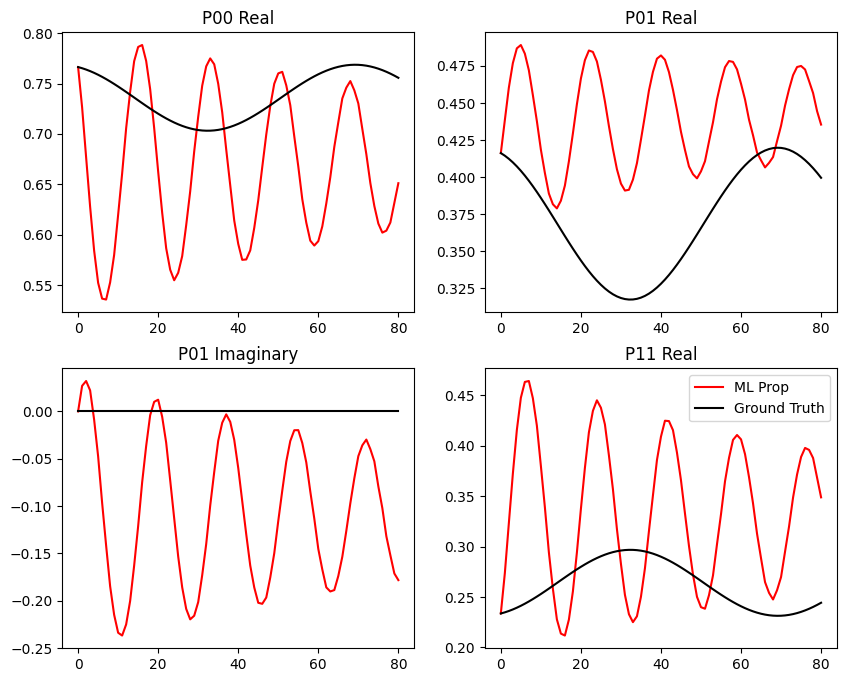

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
i = 46
ic = allden[i][0,:,:].reshape((-1))
mlprop = MMUT_Prop_HSB(trainedtheta, ic)
print(0.5*jnp.linalg.norm(mlprop - allden[i][:mynumsteps+1,:,:])**2)
axs[0,0].plot(mlprop[:,0,0].real, color='red')
axs[0,0].plot(jnp.real(allden[i][:mynumsteps+1,0,0]),color='black')
axs[0,0].set_title('P'+str(0)+str(0)+' Real')

axs[0,1].plot(mlprop[:,0,1].real, color='red')
axs[0,1].plot(jnp.real(allden[i][:mynumsteps+1,0,1]),color='black')
axs[0,1].set_title('P'+str(0)+str(1)+' Real')

axs[1,0].plot(mlprop[:,0,1].imag, color='red')
axs[1,0].plot(jnp.imag(allden[i][:mynumsteps+1,0,1]),color='black')
axs[1,0].set_title('P'+str(0)+str(1)+' Imaginary')

axs[1,1].plot(mlprop[:,1,1].real, color='red')
axs[1,1].plot(jnp.real(allden[i][:mynumsteps+1,1,1]),color='black')
axs[1,1].set_title('P'+str(1)+str(1)+' Real')
#plt.savefig('linear_model_posttrain_total_mean.pdf')
plt.legend(['ML Prop', 'Ground Truth'])
plt.show()
plt.close()

2.668789150715893


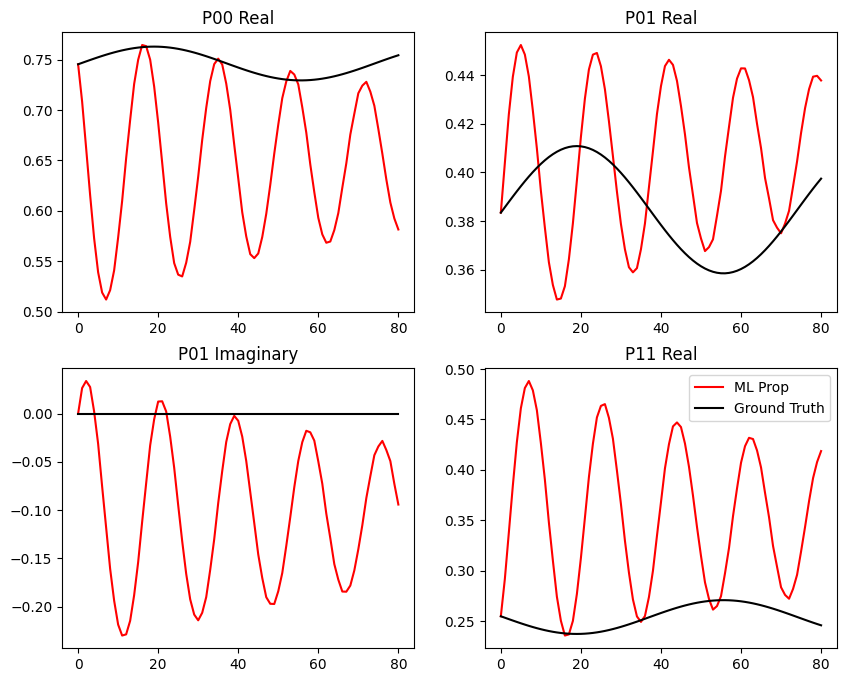

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
i = 25
ic = allden[i][0,:,:].reshape((-1))
mlprop = MMUT_Prop_HSB(trainedtheta, ic)
print(0.5*jnp.linalg.norm(mlprop - allden[i][:mynumsteps+1,:,:])**2)
axs[0,0].plot(mlprop[:,0,0].real, color='red')
axs[0,0].plot(jnp.real(allden[i][:mynumsteps+1,0,0]),color='black')
axs[0,0].set_title('P'+str(0)+str(0)+' Real')

axs[0,1].plot(mlprop[:,0,1].real, color='red')
axs[0,1].plot(jnp.real(allden[i][:mynumsteps+1,0,1]),color='black')
axs[0,1].set_title('P'+str(0)+str(1)+' Real')

axs[1,0].plot(mlprop[:,0,1].imag, color='red')
axs[1,0].plot(jnp.imag(allden[i][:mynumsteps+1,0,1]),color='black')
axs[1,0].set_title('P'+str(0)+str(1)+' Imaginary')

axs[1,1].plot(mlprop[:,1,1].real, color='red')
axs[1,1].plot(jnp.real(allden[i][:mynumsteps+1,1,1]),color='black')
axs[1,1].set_title('P'+str(1)+str(1)+' Real')
#plt.savefig('linear_model_posttrain_total_mean_test.pdf')
plt.legend(['ML Prop', 'Ground Truth'])
plt.show()
plt.close()

In [22]:
print(0.5*jnp.linalg.norm(mlprop - allden[46][:mynumsteps+1,:,:])**2)
print(0.5*jnp.linalg.norm(mlprop - allden[i][:mynumsteps+1,:,:])**2)

2.680978997288889
2.668789150715893


In [23]:
# i = 99
# ic = allden[i][0,:,:].reshape((-1))
# mynumsteps = 4000
# mydenham = MMUT_Save_Ham(trainedtheta, ic, tmeoff=alltme[i], fldfrq=allfrq[i], fldamp=allamp[i])
# trdenham = MMUT_Save_Ham(thetatrue, ic, tmeoff=alltme[i], fldfrq=allfrq[i], fldamp=allamp[i])

# print("Hamiltonian errors")
# print( jnp.mean(jnp.square(jnp.abs(mydenham[1][:,0,1] - trdenham[1][:,0,1]))) )
# print( jnp.mean(jnp.square(jnp.abs(mydenham[1][:,1,0] - trdenham[1][:,1,0]))) )
# print( jnp.mean(jnp.square(jnp.abs((mydenham[1][:,1,1] - mydenham[1][:,0,0]) - (trdenham[1][:,1,1] - trdenham[1][:,0,0])))) )

# mycom = jnp.einsum('aij,ajk->aik',mydenham[1],mydenham[0][:-1,:,:]) - jnp.einsum('aij,ajk->aik',mydenham[0][:-1,:,:],mydenham[1])
# trcom = jnp.einsum('aij,ajk->aik',trdenham[1],trdenham[0][:-1,:,:]) - jnp.einsum('aij,ajk->aik',trdenham[0][:-1,:,:],trdenham[1])
# print("Commutator error: ")
# print(jnp.mean(jnp.square(jnp.abs(mycom - trcom))))